# Finland Population and Real Estate Modelling

## Runtime Setup

In [1]:
# data processing
import pandas as pd
import numpy as np

# statistics
import statsmodels.api as sm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Artifacts and Constants

In [2]:
population_real_estate_finland_file_path = "../data/preprocessed/population_real_estate_fin.csv"

## Data Loading

In [3]:
population_real_estate_finland = pd.read_csv(population_real_estate_finland_file_path)
population_real_estate_finland.head()

,Year,Province,"Average age, both sexes","Average age, men","Average age, women",Citizens of foreign countries,Demographic dependency ratio,Economic dependency ratio,Finnish speakers,Foreign-language speakers,...,"Annual change, %","Annual change, % (real price index)",Average area m2,Index,Lower quartile,Medianprice,Number,Price per square meter (EUR/m2),Real price index,Upper quartile
0,2015,Eastern Finland,45.030691,43.614491,46.397441,11391.0,74.051163,193.097674,546426.0,16148.0,...,NaN,NaN,4189.0,95.6,1.5,4.7,74.0,10.0,95.5,13.7
1,2015,Northern Finland,41.411696,40.261485,42.598357,12539.0,71.769492,185.086441,647500.0,15790.0,...,NaN,NaN,3766.0,90.4,1.7,7.4,128.0,7.7,90.3,22.5
2,2015,Southern Finland,40.918147,39.496620,42.217560,133971.0,64.540000,146.645000,1580028.0,198794.0,...,NaN,NaN,2669.0,99.1,8.6,35.0,318.0,32.3,99.0,75.8
3,2015,Western Finland,42.959321,41.516291,44.357175,70521.0,71.039634,158.221341,2082114.0,97236.0,...,NaN,NaN,2565.0,101.3,4.3,13.6,206.0,13.7,101.2,33.6
4,2016,Eastern Finland,45.244514,43.845629,46.604816,12096.0,75.934884,191.344186,542865.0,17351.0,...,-17.4,-18.0,3927.0,78.9,1.9,5.0,74.0,7.0,78.3,15.0


## Modelling
The experiment simply tries to find relations between the population dynamics and changes in real estate prices in the years that follow.
The goal is to find population features that explain future price changes.

In [4]:
feature_cols = [
    "Average age, both sexes",
    "Demographic dependency ratio",
    "Economic dependency ratio",
    "Finnish speakers",
    "Sami speakers",
    "Swedish speakers",
    "Persons with foreign background",
    "Population 31 Dec",
    "Share of persons aged 65 or over, %",
    "Share of persons aged under 15, %"
]

target_col = "Real price index"

### Prepare features (population data as lagging indicator)

In [5]:
# extract feature columns
population_features = population_real_estate_finland[feature_cols + ["Province", "Year"]].copy()

# calculate relative change between years
population_features[feature_cols] = (
    population_features
    .sort_values(["Province", "Year"])
    .groupby("Province")[feature_cols]
    .pct_change(fill_method=None)
)

# fill nas in economic dependency with zeros
population_features["Economic dependency ratio"] = population_features["Economic dependency ratio"].fillna(0)

# remove first year with missing values
population_features = population_features[population_features["Year"] > population_features["Year"].min()]

# give the features a time lag to create a predictive model
population_features["Year"] = population_features["Year"] + 1
population_features

,"Average age, both sexes",Demographic dependency ratio,Economic dependency ratio,Finnish speakers,Sami speakers,Swedish speakers,Persons with foreign background,Population 31 Dec,"Share of persons aged 65 or over, %","Share of persons aged under 15, %",Province,Year
4,0.004748,0.025438,-0.009081,-0.006517,-0.200000,0.013333,0.073663,-0.004178,0.024211,-0.009118,Eastern Finland,2017
5,0.006048,0.029378,-0.013983,-0.002366,0.004125,0.011209,0.089508,-0.000114,0.027653,-0.007607,Northern Finland,2017
6,0.002858,0.021150,0.002250,0.001282,0.015873,-0.002719,0.074702,0.008815,0.017250,-0.003453,Southern Finland,2017
7,0.004727,0.022102,-0.007361,-0.002223,0.050847,0.000020,0.067424,0.000890,0.021384,-0.004884,Western Finland,2017
8,0.006097,0.035465,-0.017842,-0.008181,0.083333,0.018092,0.023604,-0.007138,0.031665,-0.008935,Eastern Finland,2018
9,0.006594,0.028746,-0.030342,-0.003039,0.007042,0.028504,0.042866,-0.001684,0.031908,-0.006843,Northern Finland,2018
10,0.005185,0.020825,-0.022521,0.001533,0.070312,-0.002077,0.057912,0.007762,0.018805,-0.002461,Southern Finland,2018
11,0.004905,0.025596,-0.030465,-0.002426,0.008065,-0.000303,0.051001,0.000178,0.022867,-0.006751,Western Finland,2018
12,0.007175,0.035285,-0.017176,-0.008828,0.230769,-0.006462,0.022067,-0.007859,0.027233,-0.010284,Eastern Finland,2019
13,0.006997,0.028434,-0.027422,-0.003109,-0.000583,0.016166,0.036091,-0.001946,0.029749,-0.012963,Northern Finland,2019


### Prepare target variable (real price changes of real estate)

In [6]:
# extract target column
real_estate_target = population_real_estate_finland[[target_col, "Province", "Year"]].copy()

# calculate relative price change
real_estate_target[target_col] = (
    real_estate_target
    .sort_values(["Province", "Year"])
    .groupby("Province")[target_col]
    .pct_change(fill_method=None)
)

real_estate_target = real_estate_target[real_estate_target["Year"] > real_estate_target["Year"].min()]

real_estate_target

,Real price index,Province,Year
4,-0.180105,Eastern Finland,2016
5,0.187154,Northern Finland,2016
6,0.007071,Southern Finland,2016
7,-0.129447,Western Finland,2016
8,-0.006386,Eastern Finland,2017
9,-0.158582,Northern Finland,2017
10,-0.019057,Southern Finland,2017
11,0.085131,Western Finland,2017
12,0.195373,Eastern Finland,2018
13,-0.024390,Northern Finland,2018


### Define data as input for model

In [7]:
training_data = pd.merge(
    real_estate_target,
    population_features,
    on=["Province", "Year"],
    how="inner"
)

training_data = training_data.drop(columns=["Year", "Province"])

training_data

,Real price index,"Average age, both sexes",Demographic dependency ratio,Economic dependency ratio,Finnish speakers,Sami speakers,Swedish speakers,Persons with foreign background,Population 31 Dec,"Share of persons aged 65 or over, %","Share of persons aged under 15, %"
0,-0.006386,0.004748,0.025438,-0.009081,-0.006517,-0.200000,0.013333,0.073663,-0.004178,0.024211,-0.009118
1,-0.158582,0.006048,0.029378,-0.013983,-0.002366,0.004125,0.011209,0.089508,-0.000114,0.027653,-0.007607
2,-0.019057,0.002858,0.021150,0.002250,0.001282,0.015873,-0.002719,0.074702,0.008815,0.017250,-0.003453
3,0.085131,0.004727,0.022102,-0.007361,-0.002223,0.050847,0.000020,0.067424,0.000890,0.021384,-0.004884
4,0.195373,0.006097,0.035465,-0.017842,-0.008181,0.083333,0.018092,0.023604,-0.007138,0.031665,-0.008935
5,-0.024390,0.006594,0.028746,-0.030342,-0.003039,0.007042,0.028504,0.042866,-0.001684,0.031908,-0.006843
6,0.056237,0.005185,0.020825,-0.022521,0.001533,0.070312,-0.002077,0.057912,0.007762,0.018805,-0.002461
7,0.002092,0.004905,0.025596,-0.030465,-0.002426,0.008065,-0.000303,0.051001,0.000178,0.022867,-0.006751
8,-0.072043,0.007175,0.035285,-0.017176,-0.008828,0.230769,-0.006462,0.022067,-0.007859,0.027233,-0.010284
9,0.162500,0.006997,0.028434,-0.027422,-0.003109,-0.000583,0.016166,0.036091,-0.001946,0.029749,-0.012963


In [8]:
corr = training_data.corr(method="spearman")[target_col].sort_values(ascending=False)
corr = corr.drop(target_col).sort_values(ascending=False).reset_index()
corr.columns = ["Variable", "Correlation"]

corr

,Variable,Correlation
0,"Share of persons aged 65 or over, %",0.212610
1,Demographic dependency ratio,0.203446
2,"Average age, both sexes",0.140396
3,Sami speakers,0.076817
4,Economic dependency ratio,0.068182
5,"Share of persons aged under 15, %",-0.056452
6,Finnish speakers,-0.056818
7,Swedish speakers,-0.065249
8,Population 31 Dec,-0.199780
9,Persons with foreign background,-0.207845


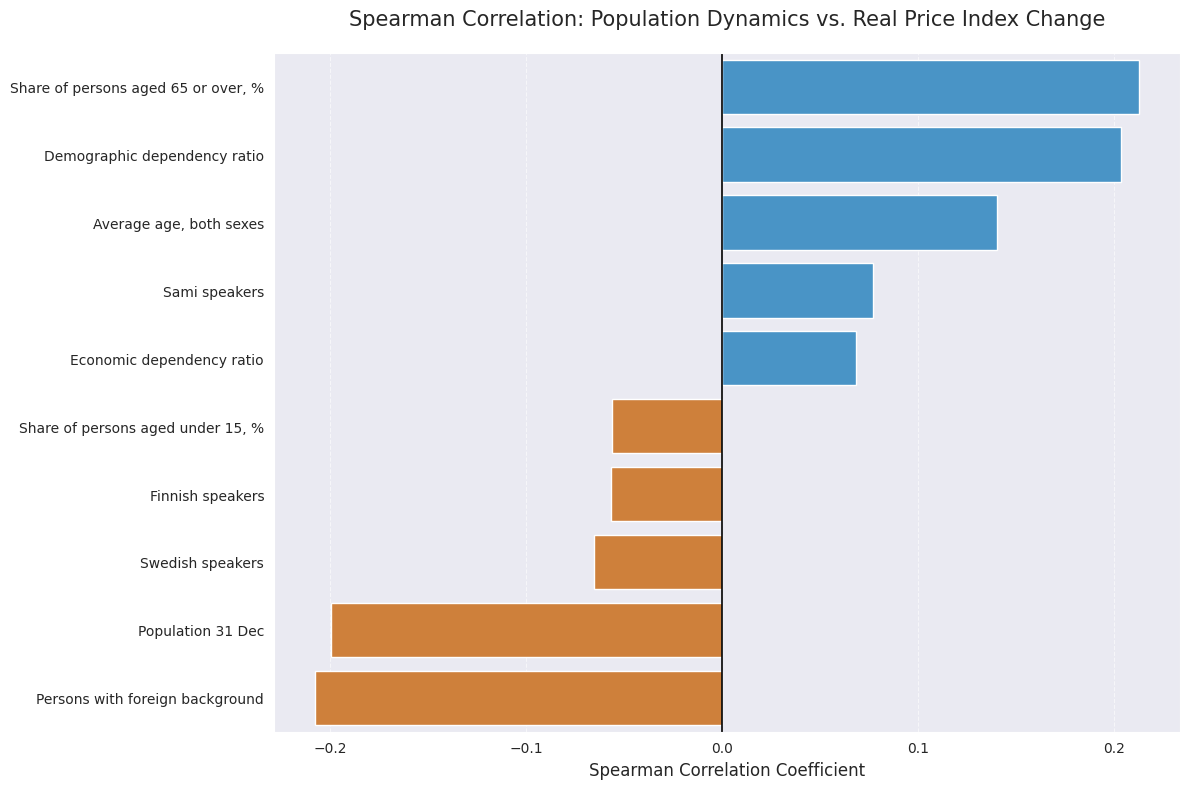

In [11]:
plt.figure(figsize=(12, 8))
palette = ['#3498db' if x > 0 else '#e67e22' if x < 0 else '#95a5a6' for x in corr["Correlation"]]

sns.barplot(
    x="Correlation",
    y="Variable",
    data=corr,
    palette=palette,
    hue="Variable"
)

plt.axvline(0, color="black", linewidth=1.2)
plt.title("Spearman Correlation: Population Dynamics vs. Real Price Index Change", fontsize=15, pad=20)
plt.xlabel("Spearman Correlation Coefficient", fontsize=12)
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

In [10]:
X = training_data.drop(columns=[target_col])
y = training_data[target_col]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Real price index   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     1.319
Date:                Tue, 23 Dec 2025   Prob (F-statistic):              0.283
Time:                        02:16:38   Log-Likelihood:                 13.621
No. Observations:                  32   AIC:                            -5.242
Df Residuals:                      21   BIC:                             10.88
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.5725      0.441     -1.297      0.209      -1.490       0.346
Average age, both sexes               -60.5459     73.972     -0.818      0.422    -214.379      93.287
Demographic dependency ratio           11.9391     12.809      0.932      0.362     -14.698      38.576
Economic dependency ratio               0.3655      1.424      0.257      0.800      -2.595       3.326
Finnish speakers                      -11.9312     25.121     -0.475      0.640     -64.173      40.311
Sami speakers                          -0.2871      0.517     -0.555      0.585      -1.362       0.788
Swedish speakers                       -8.2365      2.727     -3.021      0.007     -13.907      -2.566
Persons with foreign background        -1.2851      1.212     -1.061      0.301      -3.805       1.235
Population 31 Dec                      28.1748     24.319      1.159      0.260     -22.400      78.750
Share of persons aged 65 or over, %    21.9755     18.870      1.165      0.257     -17.266      61.218
Share of persons aged under 15, %     -21.2973     12.456     -1.710      0.102     -47.201       4.606
==============================================================================
Omnibus:                        0.058   Durbin-Watson:                   2.604
Prob(Omnibus):                  0.971   Jarque-Bera (JB):                0.271
Skew:                          -0.015   Prob(JB):                        0.873
Kurtosis:                       2.550   Cond. No.                     2.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""